# ERA5 Wind Field Demonstration Notebook

You should **download** your ERA5 wind field data from the following link:
https://drive.google.com/file/d/1Y5ocrCH0TVf9ZDkVGaJ03ftUrtKEVxIf/view?usp=sharing

Download the data and save it into your Google Drive.

In [ ]:
# Clone the repository
!git clone https://github.com/sdean-group/balloon-outreach.git
%cd balloon-outreach
!git checkout v0

Cloning into 'balloon-outreach'...
remote: Enumerating objects: 787, done.
remote: Counting objects: 100% (426/426), done.
remote: Compressing objects: 100% (236/236), done.
remote: Total 787 (delta 260), reused 296 (delta 190), pack-reused 361 (from 1)
Receiving objects: 100% (787/787), 37.05 MiB | 17.19 MiB/s, done.
Resolving deltas: 100% (470/470), done.
/content/balloon-outreach
Already on 'v0'
Your branch is up to date with 'origin/v0'.


In [ ]:
!pip install xarray==2025.4.0
!pip install netCDF4
!pip install opensimplex
!pip install cartopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 11.6 MB/s eta 0:00:00
  Attempting uninstall: xarray
    Found existing installation: xarray 2025.3.1
    Uninstalling xarray-2025.3.1:
      Successfully uninstalled xarray-2025.3.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 58.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 49.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.0/268.0 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 93.9 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sys
sys.path.append('/content/balloon-outreach/')

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
from math import cos, radians
from datetime import datetime
from env.ERA_wind_field import WindField


datapath = "/content/drive/MyDrive/era5_data.nc"

## Description of dataset in NetCDF4 format

It contains
- data samples obtained from 2024-07-01 00:00 to 2024-07-05 23:00 (hourly data)
- pressure levels: 100 hPa, 200 hPa, 300 hPa, 500 hPa, 700 hPa, 850 hPa, 1000 hPa
- latitude : 0.0 ~ 90.0 (with interval 0.25)
- longitude : -180.0 ~ 179.75 (with interval 0.25)
- u/v component of wind vector for each (valid_time, pressure_level, latitude, longitude)

In [ ]:
ds = xr.open_dataset(datapath, engine='netcdf4')
print(ds)

<xarray.Dataset> Size: 3GB
Dimensions:         (valid_time: 120, pressure_level: 7, latitude: 361,
                     longitude: 1440)
Coordinates:
    number          int64 8B ...
  * valid_time      (valid_time) datetime64[ns] 960B 2024-07-01 ... 2024-07-0...
  * pressure_level  (pressure_level) float64 56B 1e+03 850.0 ... 200.0 100.0
  * latitude        (latitude) float64 3kB 90.0 89.75 89.5 ... 0.5 0.25 0.0
  * longitude       (longitude) float64 12kB -180.0 -179.8 ... 179.5 179.8
    expver          (valid_time) <U4 2kB ...
Data variables:
    u               (valid_time, pressure_level, latitude, longitude) float32 2GB ...
    v               (valid_time, pressure_level, latitude, longitude) float32 2GB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
  

In [ ]:
## examples

ds.valid_time[:10]

<xarray.DataArray 'valid_time' (valid_time: 10)> Size: 80B
array(['2024-07-01T00:00:00.000000000', '2024-07-01T01:00:00.000000000',
       '2024-07-01T02:00:00.000000000', '2024-07-01T03:00:00.000000000',
       '2024-07-01T04:00:00.000000000', '2024-07-01T05:00:00.000000000',
       '2024-07-01T06:00:00.000000000', '2024-07-01T07:00:00.000000000',
       '2024-07-01T08:00:00.000000000', '2024-07-01T09:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 80B 2024-07-01 ... 2024-07-01T09:...
    expver      (valid_time) <U4 160B ...
Attributes:
    long_name:      time
    standard_name:  time

In [ ]:
ds.pressure_level

<xarray.DataArray 'pressure_level' (pressure_level: 7)> Size: 56B
array([1000.,  850.,  700.,  500.,  300.,  200.,  100.])
Coordinates:
    number          int64 8B ...
  * pressure_level  (pressure_level) float64 56B 1e+03 850.0 ... 200.0 100.0
Attributes:
    long_name:         pressure
    units:             hPa
    positive:          down
    stored_direction:  decreasing
    standard_name:     air_pressure

## Plot a wind field at a certain time/pressure level

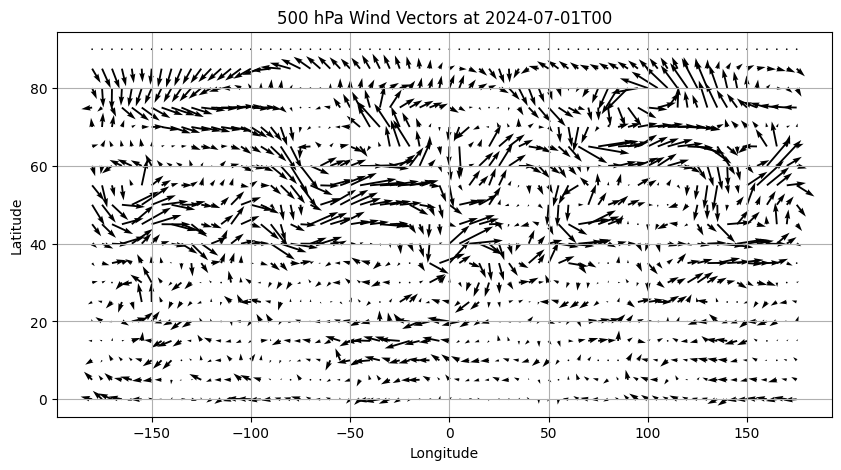

In [ ]:
# 1. Pick a pressure level (hPa) and time index
plev = ds.pressure_level[3]     # hPa
tidx = 0                        # first time step

# 2. Extract the u/v wind components and longitude/latitude coordinates
u = ds.u.sel(pressure_level=plev).isel(valid_time=tidx)
v = ds.v.sel(pressure_level=plev).isel(valid_time=tidx)
lons = ds.longitude
lats = ds.latitude

# 3. Downsample for readability
step = 20
u2 = u.values[::step, ::step]
v2 = v.values[::step, ::step]
lon2 = lons.values[::step]
lat2 = lats.values[::step]

# 4. Build a title string with the datetime
time_str = np.datetime_as_string(ds.valid_time.values[tidx], unit='h')

# 5. Plot
plt.figure(figsize=(10, 5))
plt.quiver(lon2, lat2, u2, v2, scale=700)                   # adjust scale to taste
plt.title(f"{int(plev)} hPa Wind Vectors at {time_str}")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()


## Draw a (noisy) wind vector via interpolation

In [ ]:
# 1. pick a reference start_time (should match your dataset’s first valid_time)
start_time = datetime(2024, 7, 1, 0, 0)

# 2. wrap it, giving an explicit seed for reproducibility
start = time.time()
wf = WindField(ds, start_time, noise_seed=None)
end = time.time()
print(f"WindField initialized for {end - start:.4f} seconds. \n")

# 3. query at (lon, lat, pressure, elapsed_time)
start = time.time()
wf.disable_noise()
pt = wf.get_wind(
    lon          = -75.04,
    lat          =  40.33,
    pressure     =  400.0,
    elapsed_time =  1.3  # in hours
)
end=time.time()
print(f"Noiseless: u={pt.u:.2f}, v={pt.v:.2f}")
print(f"Elapsed: {end - start:.4f} seconds")
print('\n')

wf.enable_noise(noise_seed=None)
print("Noisy Samples")
for i in range(5):
    start = time.time()
    wf.reset_noise(noise_seed=i)   # picks a fresh random seed internally
    pt = wf.get_wind(
        lon          = -75.04,
        lat          =  40.33,
        pressure     =  400.0,
        elapsed_time =  1.3  # in hours
    )
    end=time.time()
    print(f"draw {i+1}: u={pt.u:.2f}, v={pt.v:.2f}")
    print(f"Elapsed: {end - start:.4f} seconds\n")

WindField initialized for 36.0481 seconds. 

Noiseless: u=28.24, v=7.70
Elapsed: 0.0013 seconds


Noisy Samples
draw 1: u=27.49, v=6.28
Elapsed: 8.4446 seconds

draw 2: u=27.61, v=8.13
Elapsed: 0.0161 seconds

draw 3: u=29.28, v=7.13
Elapsed: 0.0158 seconds

draw 4: u=31.84, v=8.93
Elapsed: 0.0153 seconds

draw 5: u=28.75, v=8.55
Elapsed: 0.0161 seconds



## How a balloon (or a particle) would move at a fixed pressure level (altitude) without taking any actions

- Plot trajectory of a balloon given an initial position.
- No physical concept on the balloon.

/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_ocean.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


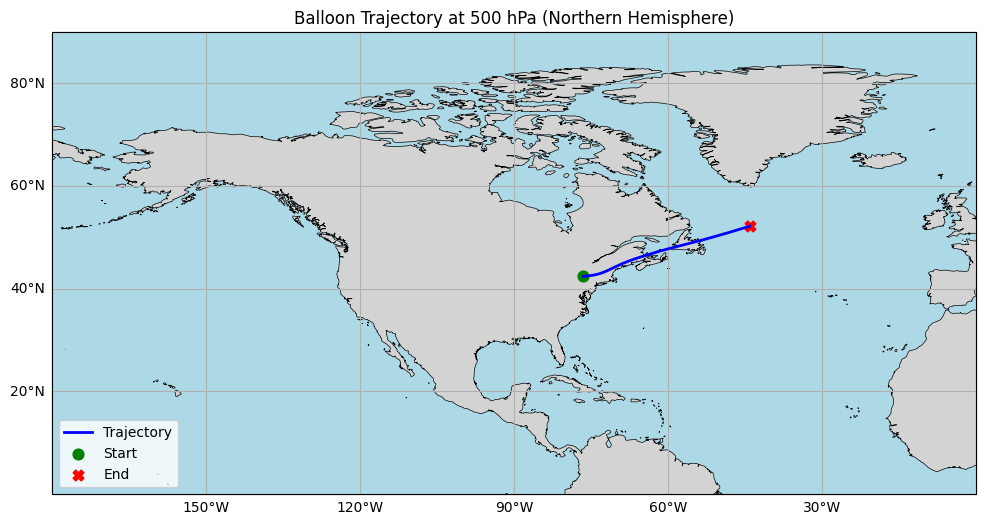

In [ ]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# --- PARAMETERS ---
pressure_level = 500               # in hPa
initial_lon, initial_lat = -76.5, 42.4  # Initial point (Ithaca) (degrees)
duration_seconds = 24 * 3600       # total integration time (e.g. 24 h)
dt_seconds = 60                 # time step for integration (e.g. 1 h = 3600 s)

# --- SET UP WIND FIELD ---
start_time_np = ds.valid_time.values[0]
start_time = pd.to_datetime(start_time_np).to_pydatetime()
wf = WindField(ds, start_time=start_time)
wf.disable_noise()

# --- SIMULATE TRAJECTORY ---
n_steps = int(duration_seconds / dt_seconds)
trajectory = [(initial_lon, initial_lat)]
lon, lat = initial_lon, initial_lat

for i in range(n_steps):
    elapsed = i * dt_seconds / 3600
    w = wf.get_wind(lon, lat, pressure_level, elapsed)  # WindVector(u, v) in m/s

    # Use dt in seconds directly
    dx_km = w.u * dt_seconds / 1000.0
    dy_km = w.v * dt_seconds / 1000.0

    # Convert km → degrees
    dlat = dy_km / 111.0
    dlon = dx_km / (111.0 * cos(radians(lat)))

    lon += dlon
    lat += dlat
    trajectory.append((lon, lat))

lons, lats = zip(*trajectory)

fig, ax = plt.subplots(
    figsize=(12,6),
    subplot_kw={'projection': ccrs.PlateCarree()}
)

ax = plt.axes(projection=ccrs.PlateCarree())

# around the North America
lon_min, lon_max = -180, 0
lat_min, lat_max = 0, 90
ax.set_extent([lon_min, lon_max, lat_min, lat_max],
              crs=ccrs.PlateCarree())

# add background
ax.add_feature(cfeature.LAND.with_scale('50m'), facecolor='lightgray')
ax.add_feature(cfeature.OCEAN.with_scale('50m'), facecolor='lightblue')
ax.coastlines('50m', linewidth=0.5)

# gridlines with labels
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl.top_labels = False
gl.right_labels = False

# plot trajectory
ax.plot(lons, lats,
        transform=ccrs.PlateCarree(),
        color='blue', linewidth=2,
        label='Trajectory')

# start and end markers
ax.scatter(lons[0], lats[0],
           transform=ccrs.PlateCarree(),
           color='green', marker='o', s=60,
           label='Start')
ax.scatter(lons[-1], lats[-1],
           transform=ccrs.PlateCarree(),
           color='red', marker='X', s=60,
           label='End')

ax.set_title(f"Balloon Trajectory at {pressure_level} hPa (Northern Hemisphere)")
ax.set_xlabel("Longitude (°E)")
ax.set_ylabel("Latitude (°N)")
ax.legend(loc='lower left')

plt.show()

## How a balloon (or a particle) would move given a profile of pressure level (altitude) without taking any actions

- Plot trajectory of a balloon given an initial position.
- No physical concept on the balloon.

/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_ocean.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


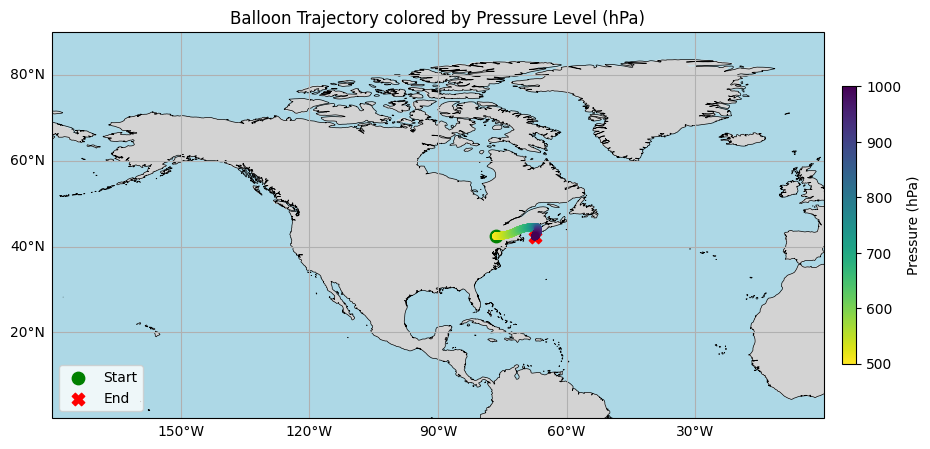

In [ ]:
# --- PARAMETERS ---
# instead of one fixed level, give a profile array of length n_steps+1
# e.g. linearly from 500→1000 hPa over 24 h at 1 min (60 dt_seconds) steps:

duration_seconds = 24*3600
dt_seconds = 60
n_steps = int(duration_seconds / dt_seconds)
pressure_profile = np.linspace(500, 1000, n_steps+1)  # shape (n_steps+1,)

initial_lon, initial_lat = -76.5, 42.4  # Initial point (Ithaca) (degrees)
start_time = pd.to_datetime(ds.valid_time.values[0]).to_pydatetime()
wf = WindField(ds, start_time=start_time)
wf.disable_noise()

# --- SIMULATE TRAJECTORY WITH VARIABLE PRESSURE ---
trajectory = [(initial_lon, initial_lat)]
lon, lat = initial_lon, initial_lat

for i in range(n_steps):
    elapsed_h = (i * dt_seconds) / 3600.0
    plev = pressure_profile[i]                    # pick level for this step
    w = wf.get_wind(lon, lat, plev, elapsed_h)     # WindVector(u, v) in m/s

    # displacement in km
    dx_km = w.u * dt_seconds / 1000.0
    dy_km = w.v * dt_seconds / 1000.0

    # convert to degrees
    dlat = dy_km / 111.0
    dlon = dx_km / (111.0 * cos(radians(lat)))

    lon += dlon
    lat += dlat
    trajectory.append((lon, lat))

lons, lats = zip(*trajectory)

fig, ax = plt.subplots(
    figsize=(12,6),
    subplot_kw={'projection': ccrs.PlateCarree()}
)

# around the North America
ax.set_extent([-180,0,0,90], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
ax.coastlines('50m', linewidth=0.5)

gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl.top_labels = False; gl.right_labels = False

# 1) Plot the trajectory line in grey
ax.plot(lons, lats,
        transform=ccrs.PlateCarree(),
        color='gray', linewidth=1, alpha=0.7)

# 2) Scatter each point, colored by pressure
sc = ax.scatter(lons, lats,
                c=pressure_profile,
                cmap='viridis_r',         # high pressure = yellow, low = purple
                s=20,
                transform=ccrs.PlateCarree(),
                zorder=5)

# 3) Start/end markers
ax.scatter(lons[0], lats[0],
           transform=ccrs.PlateCarree(),
           color='green', marker='o', s=80,
           label='Start')
ax.scatter(lons[-1], lats[-1],
           transform=ccrs.PlateCarree(),
           color='red', marker='X', s=80,
           label='End')

# 4) Colorbar for pressure
cbar = plt.colorbar(sc, ax=ax, orientation='vertical', pad=0.02, shrink=0.6)
cbar.set_label('Pressure (hPa)')

ax.set_title("Balloon Trajectory colored by Pressure Level (hPa)")
ax.set_xlabel("Longitude (°E)")
ax.set_ylabel("Latitude (°N)")
ax.legend(loc='lower left')

plt.show()
